# Grad-ECLIP: CLIP Textual Explainability

This notebook implements **Grad-ECLIP** for text-level explainability in CLIP models, identifying key words for image-text matching.


### 1. Attention-based Explanations

Leverages **attention maps** to pinpoint important words.

### 2. Gradient-based Explanations

Measures token importance via **gradients**.

### 3. Fusion of Mechanisms

Combines **attention + gradients** for robust explanations.

Let's start with using the open sourced OPENAI CLIP model


In [17]:
import re
import math
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode
import clip

from PIL import Image
from urllib.request import urlopen

import matplotlib.pyplot as plt
from captum.attr import visualization

device = "cuda" if torch.cuda.is_available() else "cpu"
clipmodel, preprocess = clip.load("ViT-B/16", device=device)

## 1. Text Data Preparation

The `pre_caption` function handles standard preprocessing for text captions. It ensures clean and consistent input by:

* **Normalizing case** and **removing punctuation**.
* **Limiting the length** to `max_words` tokens.
* **Cleaning up multiple spaces**.

This step is crucial for standardizing textual input before explainability analysis.


In [18]:
def pre_caption(caption, max_words=50):
    caption = re.sub(
        r"([.!\"()*#:;~])",
        ' ',
        caption.lower(),
    )
    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n')
    caption = caption.strip(' ')

    
    caption_words = caption.split(' ')
    if len(caption_words) > max_words:
        caption = ' '.join(caption_words[:max_words])

    return caption

## 2. Attention Mechanism and Dense Encoding

### Attention Layer

The `attention_layer` function implements multi-head attention using the formula:

$$
\text{Attention}(Q,K,V) = \text{softmax}(QK^T/\sqrt{d_k})V
$$

Where:

* $Q, K, V$ are the Query, Key, and Value matrices.
* $d_k$ is the dimension of the keys.
* The scaling factor $1/\sqrt{d_k}$ prevents softmax saturation.

### Dense Text Encoding

The `clip_encode_text_dense` function modifies the standard CLIP encoder to:

1.  **Retain intermediate representations** (Q, K, V, and attention outputs).
2.  **Compute attention maps** for each layer.
3.  **Enable gradient calculation** on attention outputs.

This modification is crucial for explainability as it provides access to the model's internal mechanisms.

In [19]:
def attention_layer(q, k, v, num_heads=1, attn_mask=None):
    "Compute 'Scaled Dot Product Attention'"
    tgt_len, bsz, embed_dim = q.shape
    head_dim = embed_dim // num_heads
    scaling = float(head_dim) ** -0.5
    q = q * scaling

    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    attn_output_weights = torch.bmm(q, k.transpose(1, 2))
    if attn_mask is not None:
        attn_output_weights += attn_mask
    attn_output_weights = F.softmax(attn_output_weights, dim=-1)
    attn_output = torch.bmm(attn_output_weights, v)
    assert list(attn_output.size()) == [bsz * num_heads, tgt_len, head_dim]
    attn_output = attn_output.transpose(
        0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, -1)
    attn_output_weights = attn_output_weights.sum(dim=1) / num_heads
    return attn_output, attn_output_weights


def clip_encode_text_dense(text, n):
    x = clipmodel.token_embedding(text).type(
        clipmodel.dtype)  # [batch_size, n_ctx, d_model]
    attn_mask = clipmodel.build_attention_mask().to(dtype=x.dtype, device=x.device)
    x = x + clipmodel.positional_embedding.type(clipmodel.dtype)
    x = x.permute(1, 0, 2)  
    x = torch.nn.Sequential(*clipmodel.transformer.resblocks[:-n])(x)

    
    attns = []
    atten_outs = []
    vs = []
    qs = []
    ks = []
    for TR in clipmodel.transformer.resblocks[-n:]:
        x_in = x
        x = TR.ln_1(x_in)
        linear = torch._C._nn.linear
        q, k, v = linear(x, TR.attn.in_proj_weight,
                         TR.attn.in_proj_bias).chunk(3, dim=-1)
        attn_output, attn = attention_layer(
            q, k, v, 1, attn_mask=attn_mask)  
        attns.append(attn)
        atten_outs.append(attn_output)
        vs.append(v)
        qs.append(q)
        ks.append(k)

        x_after_attn = linear(
            attn_output, TR.attn.out_proj.weight, TR.attn.out_proj.bias)
        x = x_after_attn + x_in
        x = x + TR.mlp(TR.ln_2(x))

    x = x.permute(1, 0, 2)  
    x = clipmodel.ln_final(x).type(clipmodel.dtype)

    
    
    x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)
          ] @ clipmodel.text_projection
    return x, (qs, ks, vs), attns, atten_outs

In [20]:
from clip import tokenize
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()


## 3. Explainability Methods

### 3.1 Q-K Similarity (`sim_qk`)

This function computes the **cosine similarity** between the `[CLS]` (end-of-sequence) token's queries and all other tokens' keys.

**Formula**: $\text{cosine\_similarity} = (q_{\text{cls}} \cdot k_{\text{patch}}) / (||q_{\text{cls}}|| \cdot ||k_{\text{patch}}||)$

This similarity metric quantifies the relative importance of each token within the attention mechanism.

---

### 3.2 Grad-ECLIP: The Core Method

`grad_eclip` implements the main algorithm from the paper, combining gradients and attention for robust explanations:

1.  **Gradient Calculation**: $\nabla_{\text{attn\_output}}(\text{cosine\_similarity})$ is computed.
2.  **Attention Weighting**: The calculated gradient is multiplied by the attention weights.
3.  **Multi-Layer Aggregation**: Contributions from all layers are summed.

**Final Formula**: $\text{importance\_score} = \sum_{\text{layers}} (\text{grad}_{\text{cls}} \times v \times \text{cosine\_qk})$

---

### 3.3 Self-Attention Baseline

`self_attn` simply extracts the attention weights from the `[CLS]` token to all other tokens. This serves as a **baseline** for comparison, highlighting the direct attention received by each token without gradient considerations.

---

In [21]:
import cv2
import numpy as np


def sim_qk(q, k):
    q_cls = F.normalize(q[eos_position, 0, :], dim=-1)
    k_patch = F.normalize(k[:, 0, :], dim=-1)

    cosine_qk = (q_cls * k_patch).sum(-1)
    cosine_qk = (cosine_qk-cosine_qk.min()) / (cosine_qk.max()-cosine_qk.min())
    return cosine_qk


def grad_eclip(c, qs, ks, vs, attn_outputs, eos_position):
    tmp_maps = []
    for q, k, v, attn_output in zip(qs, ks, vs, attn_outputs):
        grad = torch.autograd.grad(
            c,
            attn_output,
            retain_graph=True)[0]
        grad_cls = grad[eos_position, 0, :]
        
        cosine_qk = sim_qk(q, k)
        
        tmp_maps.append((grad_cls * v[:, 0, :] * cosine_qk[:, None]).sum(-1))

    emap = (F.relu_(torch.stack(tmp_maps, dim=0).sum(0)))
    emap = emap[1:eos_position].flatten()
    emap = emap / emap.sum()
    return emap


def self_attn(attns, eos_position):
    
    

    attn = attns[-1][0, eos_position, :].flatten()
    attn = attn / attn.sum()
    return attn

## 4. Pratical Example : Image's analysis

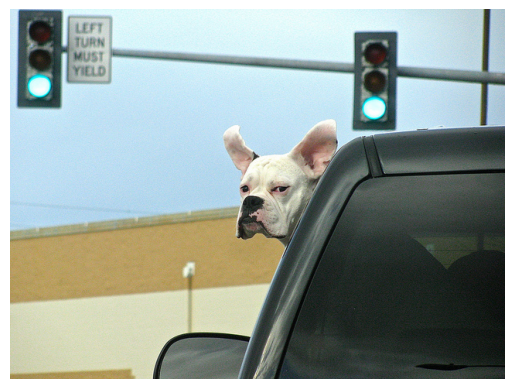

In [22]:
import os
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

img_path = "./assets/images/dog_and_car.png"
img = Image.open(img_path).convert("RGB")
sentence = "dog in a car waiting for traffic lights."


plt.imshow(img)
plt.axis('off')
plt.show()

## 5. Image Encoding

The image undergoes standard CLIP preprocessing transformations, which include:

* **Resizing** to 224x224 pixels.
* **RGB normalization**.
* **Encoding** by the Vision Transformer.

The resulting normalized image embedding will serve as the reference for measuring similarity with the text.

In [23]:

img_preprocessed = preprocess(img).cuda().unsqueeze(0)
img_embedding = clipmodel.encode_image(img_preprocessed)
img_embedding = F.normalize(img_embedding, dim=-1)
print("[image embedding]:", img_embedding.shape)

[image embedding]: torch.Size([1, 512])


## 6. Text Preparation

We tokenize the input sentence, which involves:

* **Converting it into numerical tokens.**
* **Adding special `[SOS]` (Start Of Sentence) and `[EOS]` (End Of Sentence) tokens.**
* **Decoding for visualization purposes.**

The **`[EOS]` token's position is crucial** as it represents the global embedding of the entire sentence within CLIP.

In [24]:

text_processed = clip.tokenize([sentence])

text_tokens = _tokenizer.encode(sentence)
text_tokens_decoded = [_tokenizer.decode([a]) for a in text_tokens]

## 7. Calculating Image-Text Similarity

We compute the **cosine similarity** between the image and text embeddings using the following formula:

$$
\text{Similarity} = (\text{embedding\_image} \cdot \text{embedding\_text}) / (||\text{embedding\_image}|| \cdot ||\text{embedding\_text}||)
$$

This similarity score is our **objective function** for explainability: we aim to understand which words contribute most significantly to this image-text correspondence.


In [25]:

x, (qs, ks, vs), attns, atten_outs = clip_encode_text_dense(
    text_processed.cuda(), n=8)
text_embedding = F.normalize(x, dim=-1)
print("[text embedding]:", text_embedding.shape)
cosine = (img_embedding @ text_embedding.T)
eos_position = text_processed.argmax(dim=-1)
print("[eos_position]:", eos_position)
print("[cosine]:", cosine)

[text embedding]: torch.Size([1, 512])
[eos_position]: tensor([10])
[cosine]: tensor([[0.2487]], device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)


## 8. Applying Grad-ECLIP

Now, let's apply our explainability method:

1.  **Gradients are calculated** for the similarity with respect to the attention outputs.
2.  These gradients are then **weighted** by the attention mechanisms.
3.  Finally, an **aggregation** step combines these values to produce an importance score for each token.

The result is a vector of scores, clearly indicating the significance of each word for the image-text correspondence.

In [26]:
grad_emap = grad_eclip(cosine[0], qs, ks, vs, atten_outs, eos_position)
print(grad_emap)

tensor([0.2876, 0.1032, 0.0350, 0.1780, 0.0533, 0.0000, 0.1460, 0.1851, 0.0116],
       device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)


## 9. Visualizing Grad-ECLIP Results

The visualization highlights the most important words according to Grad-ECLIP:

* **Color Intensity**: The darker the color, the more significant the word.
* **Normalized Scores**: Scores are normalized to sum to 1.

This method combines gradients and attention, offering a more robust explanation than attention alone.


In [27]:
vis_data_records = [visualization.VisualizationDataRecord(
    grad_emap, 0, 0, 0, 0, 0, text_tokens_decoded, 1)]
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,dog in a car waiting for traffic lights .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,dog in a car waiting for traffic lights .


## 10. Comparison with Pure Attention

For comparison, let's also visualize the raw attention weights from the `[CLS]` token.

This baseline illustrates what the model naturally "looks at," but it doesn't account for the impact on the final similarity score. The difference between this and Grad-ECLIP reveals the crucial contribution of gradients to explainability.

In [28]:
attn_word = self_attn(attns, eos_position)
vis_data_records = [visualization.VisualizationDataRecord(
    attn_word, 0, 0, 0, 0, 0, text_tokens_decoded, 1)]
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,dog in a car waiting for traffic lights .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,dog in a car waiting for traffic lights .


## 11. Batch Processing: Analyzing Multiple Image-Text Pairs

Let's now process multiple image-text pairs to analyze explainability on a larger scale and visualize the results in an organized grid.

In [29]:
image_text_pairs = [
    {
        "image_path": "./assets/images/cats.jpeg",
        "caption": "two cats sitting on top of apair of shoes.",
        "title": "Cats on Shoes"
    },
    
      {
        "image_path": "./assets/images/car.jpeg",
        "caption": "a car with some surfboards in a field.",
        "title": "dog in a car"
    },
    {
        "image_path": "./assets/images/plane.jpeg",
        "caption": "a small plane flying through a cloudy blue sky",
        "title": "Plane in the Sky"
    },
    
    {
        "image_path": "./assets/images/bird.jpeg",
        "caption": "a bird that is on a tree limb.",
        "title": "Bird on a Tree Limb"
    },
    
]

single_image_path = "./assets/images/dog_and_car.png"
multiple_captions = [
    "dog in a car waiting for traffic lights",
    "a small dog sitting in a vehicle",
    "pet animal inside an automobile",
    "canine passenger in a moving car"
]

if len(image_text_pairs) == 1:
    image_text_pairs = []
    for i, caption in enumerate(multiple_captions):
        image_text_pairs.append({
            "image_path": single_image_path,
            "caption": caption,
            "title": f"Description {i+1}"
        })

print(f"Nombre de paires image-texte : {len(image_text_pairs)}")

Nombre de paires image-texte : 4


In [30]:
def process_image_text_pair(image_path, caption):
    """
    Traite une paire image-texte et retourne les scores d'explicabilité
    """
    
    img = Image.open(image_path).convert("RGB")
    img_preprocessed = preprocess(img).cuda().unsqueeze(0)
    img_embedding = clipmodel.encode_image(img_preprocessed)
    img_embedding = F.normalize(img_embedding, dim=-1)
    
    
    text_processed = clip.tokenize([caption])
    text_tokens = _tokenizer.encode(caption)
    text_tokens_decoded = [_tokenizer.decode([a]) for a in text_tokens]
    
    
    x, (qs, ks, vs), attns, atten_outs = clip_encode_text_dense(
        text_processed.cuda(), n=8)
    text_embedding = F.normalize(x, dim=-1)
    
    
    cosine = (img_embedding @ text_embedding.T)
    eos_position = text_processed.argmax(dim=-1)
    
    
    grad_emap = grad_eclip(cosine[0], qs, ks, vs, atten_outs, eos_position)
    
    
    attn_scores = self_attn(attns, eos_position)
    
    return {
        'image': img,
        'caption': caption,
        'tokens': text_tokens_decoded,
        'grad_eclip_scores': grad_emap,
        'attention_scores': attn_scores,
        'similarity': cosine.item(),
        'eos_position': eos_position.item()
    }


results = []
for pair in image_text_pairs:
    print(f"Traitement: {pair['title']}")
    result = process_image_text_pair(pair['image_path'], pair['caption'])
    result['title'] = pair['title']
    results.append(result)
    print(f"  Similarité: {result['similarity']:.3f}")

Traitement: Cats on Shoes
  Similarité: 0.251
Traitement: dog in a car
  Similarité: 0.235
Traitement: Plane in the Sky


  Similarité: 0.230
Traitement: Bird on a Tree Limb
  Similarité: 0.231


In [31]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def add_colored_text_to_ax(tokens, scores, ax, title):
    """
    Adds color-coded text to a matplotlib Axes object based on Grad-ECLIP scores.
    Words with positive scores are green, negative are red, and neutral are white.

    Args:
        tokens (list[str]): A list of string tokens (words) from the caption.
        scores (torch.Tensor or np.ndarray): A 1D tensor or array of Grad-ECLIP scores,
                                             corresponding to each token.
        ax (matplotlib.axes.Axes): The Axes object to draw the text on.
        title (str): The title for the Axes.
    """
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.axis('off')
    ax.set_xlim(0, 1) # Set limits for text placement
    ax.set_ylim(0, 1)

    # Fix: Detach the tensor before converting to numpy if it requires grad
    if isinstance(scores, torch.Tensor):
        scores = scores.detach().cpu().numpy()
    elif not isinstance(scores, np.ndarray):
        scores = np.array(scores) # Ensure it's a numpy array if it's a list or other iterable


    # Normalize scores for color mapping
    # We want to map scores to a range where 0 is white, positive is green, negative is red.
    # Find the maximum absolute value to normalize the intensity.
    max_abs_score = np.max(np.abs(scores)) if scores.size > 0 else 1.0
    if max_abs_score == 0:
        max_abs_score = 1.0 # Prevent division by zero

    y_pos = 0.8 # Starting y-position for text
    x_pos = 0.05 # Starting x-position for text
    line_height = 0.2
    max_line_width = 0.9 # Maximum width before wrapping

    for i, token in enumerate(tokens):
        clean_token = token.replace('</w>', '').replace('<|startoftext|>', '').replace('<|endoftext|>', '').strip()
        if not clean_token:
            continue

        score = scores[i] if i < len(scores) else 0.0

        # Determine color based on score
        # Using a diverging colormap: Red for negative, Green for positive, Grey for neutral
        r, g, b = 0.9, 0.9, 0.9 # Default light grey for neutral

        if score > 0: # Green shades
            intensity = min(1.0, score / max_abs_score)
            # Make it greener, less red/blue
            r = max(0.0, 1.0 - intensity * 0.8)
            g = 0.5 + intensity * 0.5 # Brighter green for higher scores
            b = max(0.0, 1.0 - intensity * 0.8)
            color = (r, g, b)
        elif score < 0: # Red shades
            intensity = min(1.0, abs(score) / max_abs_score)
            # Make it redder, less green/blue
            r = 0.5 + intensity * 0.5 # Brighter red for higher absolute scores
            g = max(0.0, 1.0 - intensity * 0.8)
            b = max(0.0, 1.0 - intensity * 0.8)
            color = (r, g, b)
        else:
            color = (0.9, 0.9, 0.9) # Light grey for zero score

        # Estimate text width for wrapping
        # This is a rough estimate; for precise wrapping, you might need a TextPath object
        # or more complex font metric calculations.
        word_width = len(clean_token) * 0.015 * (ax.get_figure().get_figwidth() / ax.get_xlim()[1]) # Scale with font size and figure width

        if x_pos + word_width > max_line_width:
            x_pos = 0.05
            y_pos -= line_height
            if y_pos < 0: # Prevent text from going off-screen
                break # Or handle more gracefully

        ax.text(x_pos, y_pos, clean_token, color=color,
                fontsize=10, ha='left', va='top', fontweight='bold',
                bbox=dict(facecolor=color, alpha=0.3, edgecolor='none', boxstyle='round,pad=0.2'))

        x_pos += word_width + 0.01 # Add spacing between words

def visualize_results_grid(results):
    """
    Visualizes Grad-ECLIP explanations for multiple image-text pairs in a grid.

    Each grid cell displays:
    - The input image with its title, truncated caption, and similarity score.
    - A textual explanation where words are color-coded based on their Grad-ECLIP scores.
      Green indicates positive impact, red indicates negative impact, and white/grey indicates neutral.

    Below the grid, a detailed summary for each result is printed,
    listing the top 3 words with positive impact and the top 3 words with less relevance (most negative/lowest positive).

    Args:
        results (list[dict]): A list of dictionaries, where each dictionary represents
                              an image-text analysis result and must contain:
                              - 'image': The image data (e.g., NumPy array suitable for imshow).
                              - 'title': A title for the image.
                              - 'caption': The full text caption.
                              - 'similarity': The image-text similarity score (float).
                              - 'tokens': A list of token strings for the caption.
                              - 'grad_eclip_scores': A torch.Tensor or NumPy array of
                                                     Grad-ECLIP scores for each token.
    """
    n_results = len(results)
    n_cols = min(4, n_results)
    n_rows = (n_results + n_cols - 1) // n_cols

    # Adjust figure size for better readability, especially with text summaries
    # Increased height per row to accommodate image and detailed text explanation
    fig = plt.figure(figsize=(6 * n_cols, 7 * n_rows))

    for i, result in enumerate(results):
        row = i // n_cols
        col = i % n_cols

        # Image subplot
        ax_img = plt.subplot2grid((n_rows * 2, n_cols), (row * 2, col),
                                 rowspan=1, colspan=1)
        ax_img.imshow(result['image'])

        # Truncate caption for title, but show full in summary
        display_caption = result['caption']
        if len(display_caption) > 50:
            display_caption = display_caption[:47] + '...'

        ax_img.set_title(f"Image {i+1}: {result['title']}\nCaption: {display_caption}\nSimilarity: {result['similarity']:.3f}",
                        fontsize=9, fontweight='bold')
        ax_img.axis('off')

        # Grad-ECLIP explanation subplot
        ax_grad = plt.subplot2grid((n_rows * 2, n_cols), (row * 2 + 1, col),
                                  rowspan=1, colspan=1)

        # Use the add_colored_text_to_ax to visualize scores
        # Ensure scores are on CPU if they are torch tensors
        grad_scores_cpu = result['grad_eclip_scores'] # .cpu() handled inside add_colored_text_to_ax
        add_colored_text_to_ax(result['tokens'], grad_scores_cpu,
                              ax_grad, "Grad-ECLIP Scores")

    # Centralized legend for color interpretation
    # Positioning it slightly higher to avoid overlapping with tight_layout adjustments
    fig.text(0.5, 0.015, 'Legend: Red = Negative Impact, White = Neutral, Green = Positive Impact',
             ha='center', va='center', fontsize=12, fontweight='bold', color='dimgray')

    plt.tight_layout()
    # Adjust bottom margin to make space for the legend
    plt.subplots_adjust(bottom=0.04)
    plt.show()

    print("\n" + "="*80)
    print("GRAD-ECLIP ANALYSIS SUMMARY")
    print("="*80)

    for i, result in enumerate(results):
        print(f"\n--- Result {i+1}: {result['title']} ---")
        print(f"   Original Caption: \"{result['caption']}\"")
        print(f"   Image-Text Similarity: {result['similarity']:.3f}")

        grad_scores = result['grad_eclip_scores']
        tokens = result['tokens']

        if len(grad_scores) > 0 and len(tokens) > 0:
            # Ensure scores and tokens align and filter out special tokens from consideration for top/bottom
            valid_pairs = []
            for idx in range(len(tokens)):
                clean_word = tokens[idx].replace('</w>', '').replace('<|startoftext|>', '').replace('<|endoftext|>', '').strip()
                if clean_word: # Only consider non-empty, non-special tokens
                    score_val = grad_scores[idx].item() if isinstance(grad_scores, torch.Tensor) else grad_scores[idx]
                    valid_pairs.append((score_val, clean_word))

            if valid_pairs:
                # Sort by score for top/bottom
                sorted_pairs = sorted(valid_pairs, key=lambda x: x[0], reverse=True) # Descending for top positive

                # Top positive words
                top_positive_words = []
                for score_val, word in sorted_pairs[:min(3, len(sorted_pairs))]:
                    top_positive_words.append(f"{word} ({score_val:.3f})")
                print(f"   Top Positive Impact Words: {', '.join(top_positive_words) if top_positive_words else 'N/A'}")

                # Bottom (most negative or least positive) words
                bottom_negative_words = []
                # Sort in ascending order to get the least relevant (most negative or lowest positive)
                sorted_pairs_asc = sorted(valid_pairs, key=lambda x: x[0])

                for score_val, word in sorted_pairs_asc[:min(3, len(sorted_pairs_asc))]:
                    bottom_negative_words.append(f"{word} ({score_val:.3f})")
                print(f"   Least Relevant Words: {', '.join(bottom_negative_words) if bottom_negative_words else 'N/A'}")
            else:
                print("   No valid words found for score analysis.")
        else:
            print("   No Grad-ECLIP scores or tokens available for analysis.")

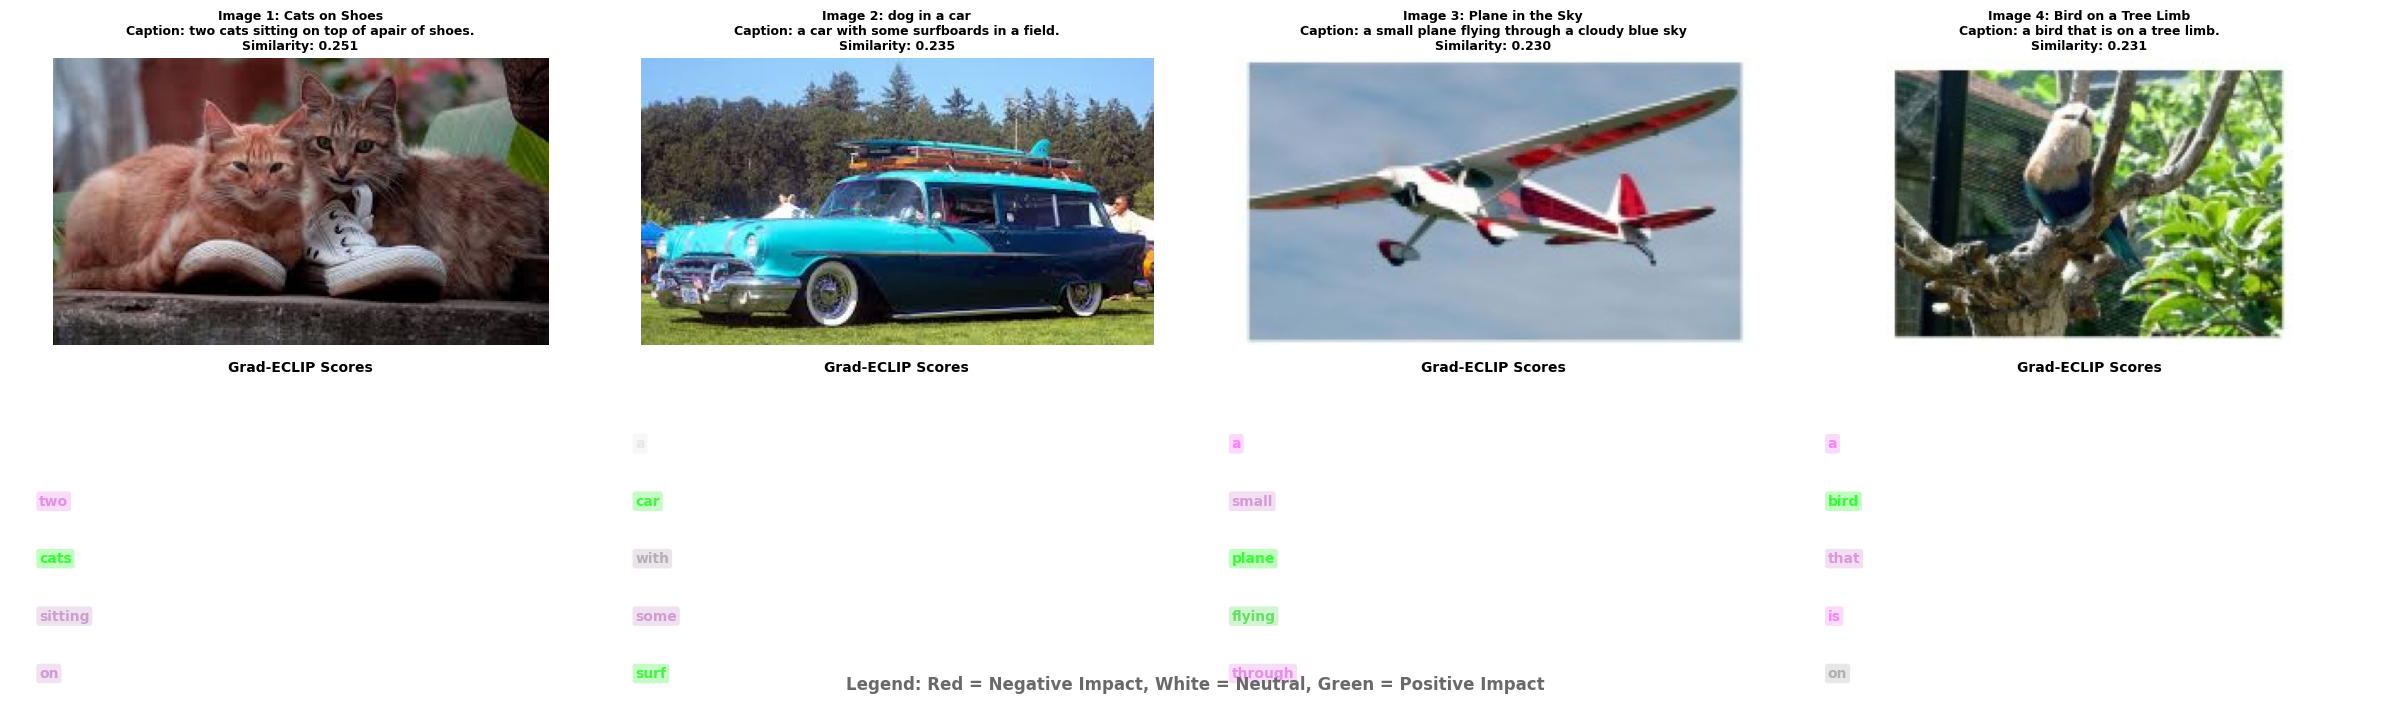


GRAD-ECLIP ANALYSIS SUMMARY

--- Result 1: Cats on Shoes ---
   Original Caption: "two cats sitting on top of apair of shoes."
   Image-Text Similarity: 0.251
   Top Positive Impact Words: cats (0.418), shoes (0.121), sitting (0.107)
   Least Relevant Words: of (0.000), . (0.000), ap (0.013)

--- Result 2: dog in a car ---
   Original Caption: "a car with some surfboards in a field."
   Image-Text Similarity: 0.235
   Top Positive Impact Words: boards (0.276), surf (0.256), car (0.251)
   Least Relevant Words: a (0.000), field (0.000), . (0.001)

--- Result 3: Plane in the Sky ---
   Original Caption: "a small plane flying through a cloudy blue sky"
   Image-Text Similarity: 0.230
   Top Positive Impact Words: plane (0.438), flying (0.333), small (0.092)
   Least Relevant Words: cloudy (0.000), a (0.001), blue (0.003)

--- Result 4: Bird on a Tree Limb ---
   Original Caption: "a bird that is on a tree limb."
   Image-Text Similarity: 0.231
   Top Positive Impact Words: bird (0.444), 

In [32]:
visualize_results_grid(results)